In [1]:
import seaborn as sns # for data visualization
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import json
import glob
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)

LOGFILES =  glob.glob('Atlas_relayPlacementT8_kpi_Log_*.json')

print(LOGFILES)

#=== line colors and styles

linestyles = {
    # scenarios
    'empty':        'dotted',
    'canonical':    'dashed',
    'floorplan':    'dashdot',
     #algorithms
    'Atlas':         'solid' ,
    'recovery':      'solid',
    'selfHealing':   'dashed',
    'naive':         'dashdot',
     #PDRs
    '1':   'solid',
    '0.9': 'solid',
    '0.8': 'solid',
    '0.7': 'solid',
    '0.6': 'solid',
    '0.5': 'solid',
    '0.4': ':',
    '0.3': 'dotted',
    '0.2': '--',
    '0.1': 'dashdot',
    'ph': 'dotted'
}

linecolors = {
    # scenarios
    'empty':        'green',
    'canonical':    'blue',
    'floorplan':    'red',
    # algorithms
    'Atlas':        '#0000ff',
    'recovery':      '#800080',
    'selfHealing':   '#FFA500',
    'naive':         '#00FF00',
    # PDRs
     '1':  'royalblue',
     '0.9': 'navy',
     '0.8': 'darkcyan',
     '0.7': 'darkgreen',
     '0.6': 'darkmagenta',
     '0.5': 'r',
     '0.4': 'sienna',
     '0.3': 'firebrick',
     '0.2': 'maroon',
     '0.1': 'purple',
     'ph':  'green'
}

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

['Atlas_relayPlacementT8_kpi_Log_210908180803.json']


In [2]:

#=== gather data

log = []
for logfile in LOGFILES:
    with open(logfile,'r') as f:
        for line in f:
            log += [json.loads(line)]
            
lastRunNum = None
runNums    = 0
for run in log:
    if run['runNums']!= lastRunNum:
        runNums      += 1
        lastRunNum    = run['runNums']
            
print('runNums: {} TotalRuns: {}'.format(runNums,len(log)))

runNums: 1 TotalRuns: 1


22
recovery Atlas 22 relays: 11 numDotBots 50 t2c 411


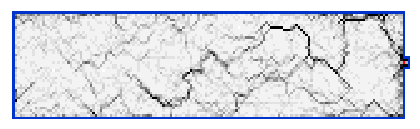

\newcommand{\heatmapMaxNumRobotsemptyAtlas}         {22\xspace}


In [3]:
'''
###############################################################################
Heatmap
###############################################################################
'''

#=== create plot

maxNumRobots = {}
plotsgenerated = []

for run in log:
    
    #if run != log[33]:
    #    continue
    
    # shorthands
    if run['floorplanType'] == 0:
        scenarioName = 'empty'
    elif run['floorplanType'] == 1:
        scenarioName = 'canonical'
    elif run['floorplanType'] == 2:
        scenarioName = 'floorplan'
     
    numRelays = run['relayProfile'][-1]
    numDotBots = run['numDotBots']
    navAlg = run['navAlgorithm']
    pdr    = run['pdr']

    # don't plot same data twice
    if (
        ((scenarioName,navAlg) in plotsgenerated) or
        ('heatmap' not in run)
    ):
        continue
    # color cells visited
    data         = np.array(run['heatmap'])
    flat         = data.flatten()
    flat.sort()
    vmax         = flat[-2] # avoid counting num robots on start position
    print(vmax)
    maxNumRobots[(scenarioName,navAlg)] = vmax
    cmap         = plt.cm.Greys
    norm         = plt.Normalize(0, 10)
    rgba         = cmap(norm(data))
    
    print(run['relayAlg'],navAlg,vmax,'relays:', numRelays, 'numDotBots',numDotBots,'t2c', run['timeToFullMapping'])
    
    # color real map
    realMap      = run['floorplanDrawing']
    x = 0

    for line in realMap.splitlines():
        if not line.startswith('-'):
             continue
        for (y,c) in enumerate(line):
            if   c=='#':
                rgba[x, y, :3] = ( 0/255,  51/255, 204/255)
            elif c=='S':
                rgba[x, y, :3] = (1,0,0) #(255/255,   0/255,   0/255)
        x += 1
    
    (fig,ax) = plt.subplots()
    im       = ax.imshow(rgba, interpolation='nearest')

    fig.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.axis('off')
    #fig.savefig('heatmap_{0}_{1}_{2}.eps'.format(scenarioName,navAlg,pdr), bbox_inches='tight')
    #fig.savefig('heatmap_{0}_{1}_{2}.png'.format(scenarioName,navAlg,pdr), bbox_inches='tight')
    
    plt.show()
    
    # remember what I have plotted
    #plotsgenerated += [(scenarioName,navAlg)]

for ((scenarioName,navAlg),num) in maxNumRobots.items():
    print('\\newcommand{{\\heatmapMaxNumRobots{}{}}}         {{{}\\xspace}}'.format(scenarioName,navAlg,num))


c:\users\abuaishe\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\users\abuaishe\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


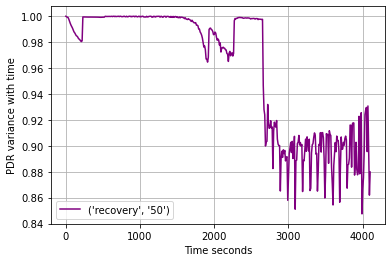

In [4]:
'''
###############################################################################
PDR Profile with Relays with various swarm sizes
###############################################################################
'''

#=== gather data
import matplotlib.ticker as mtick

data               = {}
scenarioNames      = []
allNumRobots       = []


for run in log:

    relayAlg       = run['relayAlg'] 
    numDotBots     = run['numDotBots']
    scenarioName  = str(numDotBots)
    scenarioNames += [scenarioName] 
    
    navAlg         = run['navAlgorithm'] 
    pdr            = run['pdrProfile']
    numDotBots     = run['numDotBots']
    allNumRobots  += [numDotBots]
    profile        = run['pdrProfile']
    
    if (scenarioName) not in data:
        data[(scenarioName)] = {}
    if relayAlg not in data[(scenarioName)]:
        data[(scenarioName)][relayAlg] = []
    data[(scenarioName)][relayAlg] += [profile]

for (k1,v1) in data.items():
    
    for (k2,profiles) in v1.items():
        
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = {}

    for ((scenario),v) in data.items():
#         if numDotBots!=50:
#             continue
        if scenario!=scenarioName:
            continue
        for (relayAlg,profile) in v.items():
            x1             = range(len(profile['mean']))
            x             = [x*10 for x in x1]
            y             = profile['mean']
            yerr          = profile['confidence_interval']
            lines[relayAlg] = ax.errorbar(x=x,y=y,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label= (relayAlg, scenario))
    ax.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=7000, decimals=None, symbol='%', is_latex=False))
    plt.xlabel('Time seconds')
    
    #plt.xlim(0, 300)
    plt.ylabel('PDR variance with time')

    #plt.ylim(0, 1)
    plt.legend()
    alllines = lines
    plt.show()
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')

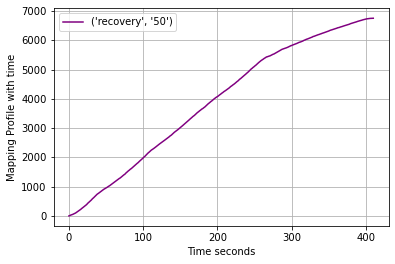

In [5]:
'''
###############################################################################
Mapping Profile with Relays with various swarm sizes
###############################################################################
'''

#=== gather data
import matplotlib.ticker as mtick

data               = {}
scenarioNames      = []
allNumRobots       = []


for run in log:

    relayAlg       = run['relayAlg'] 
    numDotBots     = run['numDotBots']
    scenarioName  = str(numDotBots)
    scenarioNames += [scenarioName] 
    
    navAlg         = run['navAlgorithm'] 
    pdr            = run['pdrProfile']
    numDotBots     = run['numDotBots']
    allNumRobots  += [numDotBots]
    profile        = run['profile']
    
    if (scenarioName) not in data:
        data[(scenarioName)] = {}
    if relayAlg not in data[(scenarioName)]:
        data[(scenarioName)][relayAlg] = []
    data[(scenarioName)][relayAlg] += [profile]

for (k1,v1) in data.items():
    
    for (k2,profiles) in v1.items():
        
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = {}

    for ((scenario),v) in data.items():
#         if numDotBots!=50:
#             continue
        if scenario!=scenarioName:
            continue
        for (relayAlg,profile) in v.items():
            x             = range(len(profile['mean']))
            #x             = [x*10 for x in x1]
            y             = profile['mean']
            yerr          = profile['confidence_interval']
            lines[relayAlg] = ax.errorbar(x=x,y=y,color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label=(relayAlg, scenario))
    ax.grid(True, zorder=5)
    #ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=7000, decimals=None, symbol='%', is_latex=False))
    plt.xlabel('Time seconds')
    
    #plt.xlim(0, 300)
    plt.ylabel('Mapping Profile with time')

    #plt.ylim(0, 1)
    plt.legend()
    alllines = lines
    plt.show()
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')

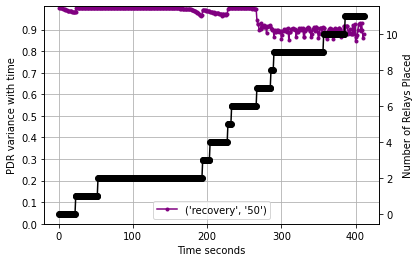

In [6]:
'''
###############################################################################
PDR vs. Time with relays
###############################################################################
'''

#=== gather data

data               = {}
scenarioNames      = []
allNumRobots       = []
pdrData            = []


for run in log:
    pdrData      = run['pdrProfile']
    timeline     = run['timeline']
    relayAlg     = run['relayAlg']
    relayProfile = run['relayProfile']
    (fig,ax)     = plt.subplots()
    ax2 = ax.twinx()

    ax.errorbar(x=timeline,y=pdrData, marker= '.',color=linecolors[relayAlg],linestyle=linestyles[relayAlg],label=(relayAlg, scenario))
    ax2.errorbar(x=timeline,y=relayProfile,marker= 'o',color='black',linestyle=linestyles[relayAlg],)
    ax.grid(True, zorder=5)
    ax.yaxis.set_ticks(np.arange(0, 1, 0.1))
    ax.set_xlabel('Time seconds')
    #plt.xlim(0, 10)
    ax.set_ylabel('PDR variance with time')
    ax2.set_ylabel('Number of Relays Placed')
    ax.legend(loc=8)
    #plt.legend()
    #plt.ylim(0, 1)
    plt.show()
    #fig.savefig('mapping_profile_{0}.eps'.format(scenarioName),bbox_inches='tight')
    #fig.savefig('mapping_profile_{0}.png'.format(scenarioName),bbox_inches='tight')